In [15]:
%matplotlib inline
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [16]:
musicdf = pd.read_csv('./musicdf30.csv', index_col=0, encoding='latin-1')

In [17]:
# Not needed now since all music samples are 30 sec
#musicdf['zero_crossing_rate'] = musicdf['zero_crossings']/musicdf['duration']

In [18]:
#Not using the Tempo labels. I am not sure if it adds any value
#musicdf = pd.concat([musicdf, pd.get_dummies(musicdf['tempo'],  drop_first=True)], axis=1)

In [19]:
# Subset of columns that would be used for clustering
feature_cols = musicdf.columns.drop(['composer', 'description', 'symphony', 'file', 'part', 'tempo', 'zero_crossings', 'duration'])

In [20]:
musicdf.shape

(61, 23)

In [21]:
df = musicdf[feature_cols]

In [22]:
df.shape

(61, 15)

In [23]:
# Scale the features (using the scale function) from -1 to 1.
## https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
df.is_copy = False
#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
#df[feature_cols] = min_max_scaler.fit_transform(df)
df[feature_cols] = preprocessing.StandardScaler().fit_transform(df[feature_cols])

In [24]:
df.head()

,bpm,spectral_centroid_avg,spectral_bw_avg,Chroma_A,Chroma_A#,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,Chroma_D#,Chroma_E,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#
0,-0.106088,0.392756,0.838097,1.341396,0.442128,-1.103446,-0.983774,0.158718,-0.596200,0.234981,1.113372,0.011579,-2.499480,-2.303520,-0.672877
1,-0.106088,-0.295178,-0.451181,0.751337,0.204818,-0.810637,-1.188572,1.149090,1.563927,-0.047121,-0.857811,-0.821154,-0.680623,-0.921784,-0.264912
2,-0.224732,1.420504,0.370527,-1.312636,-0.064678,1.843617,0.643285,-1.005027,-0.862369,0.590807,0.771229,0.434911,1.399307,-0.024772,-1.747308
3,-0.446546,0.715256,0.121119,-0.455925,0.018834,0.175453,-0.213685,1.089417,2.014804,0.903538,-1.412816,-1.564308,-0.488818,-0.382581,-0.962552
4,-0.106088,-0.094908,-0.851252,1.014053,2.376781,0.895647,-2.596445,-1.213412,1.262394,2.167771,-0.231690,-1.276952,-0.962227,-0.232267,-0.833779


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X = pca.fit_transform(df)[:,0]
Y = pca.fit_transform(df)[:,1]
Z = pca.fit_transform(df)[:,2]

In [26]:
df['x'] = X
df['y'] = Y
df['z'] = Z

Elbow curve to determine the right number of clusters

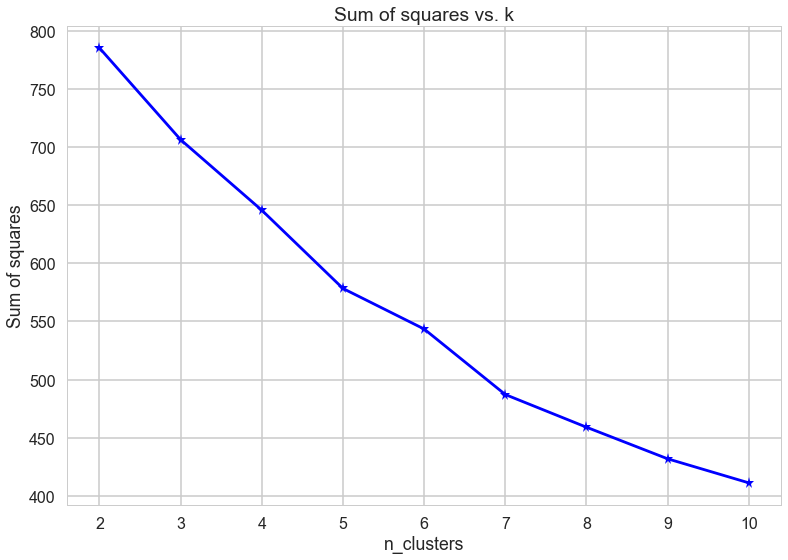

In [27]:
k_range = range(2,11)
k_means_var = [sklearn.cluster.KMeans(n_clusters=k, random_state=10).fit(df[feature_cols]) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]
from scipy.spatial import distance
k_euclid = [distance.cdist(df[feature_cols], cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, wcss, 'b*-')
#ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Sum of squares')
plt.title('Sum of squares vs. k')

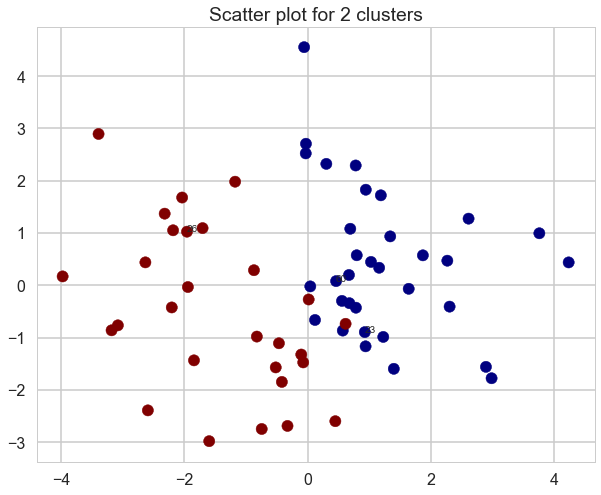

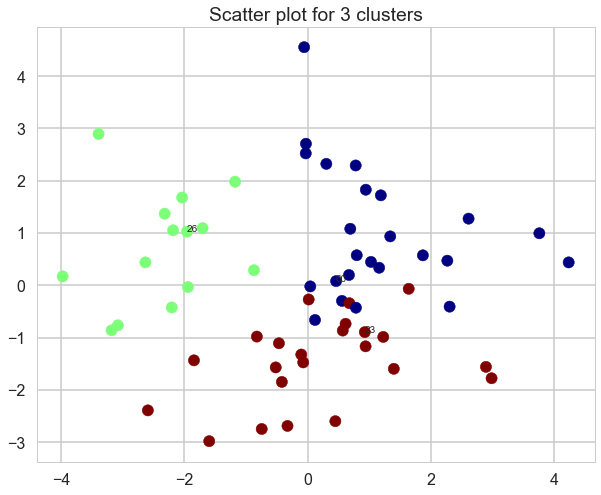

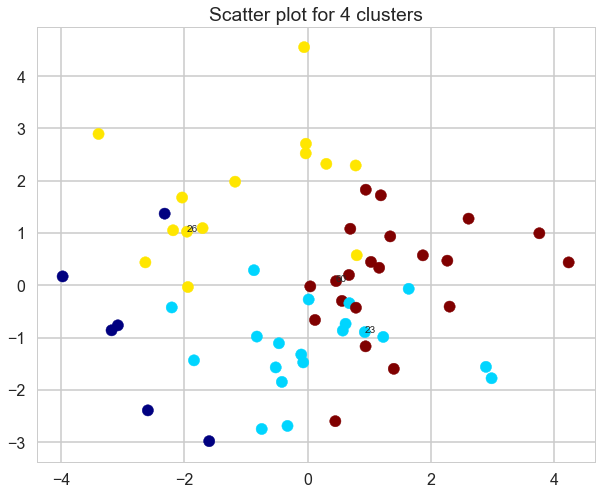

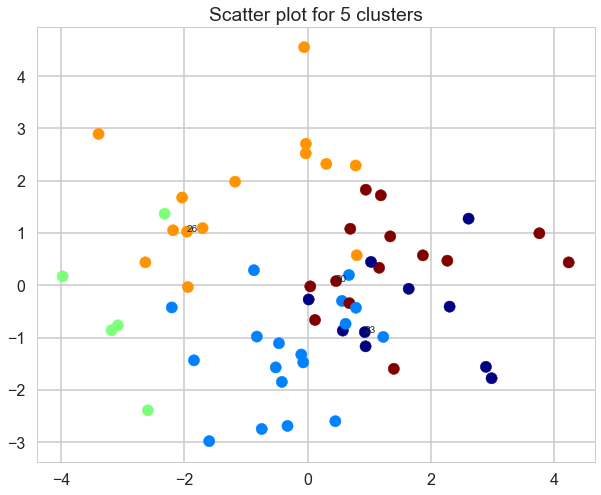

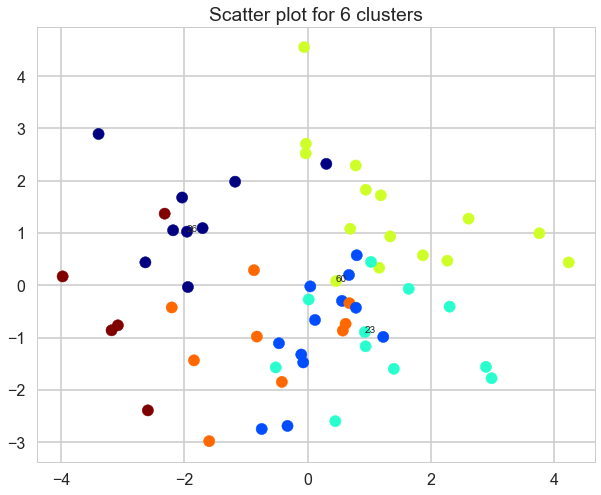

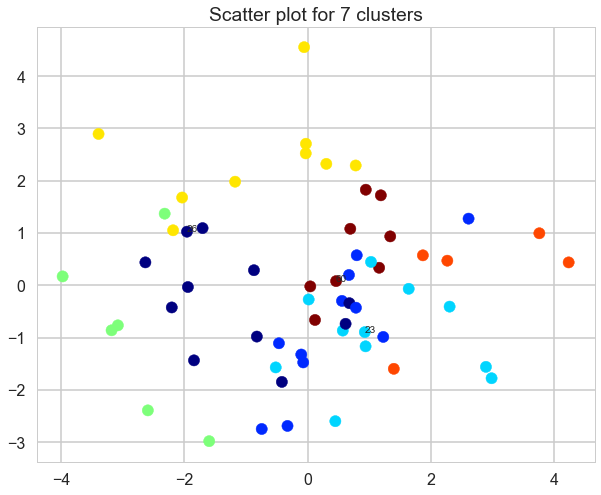

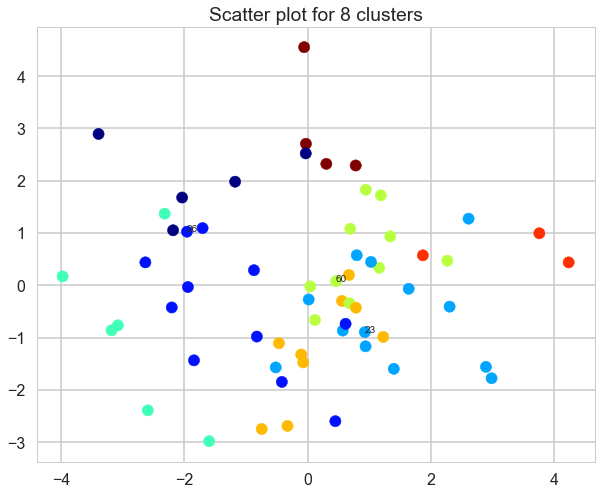

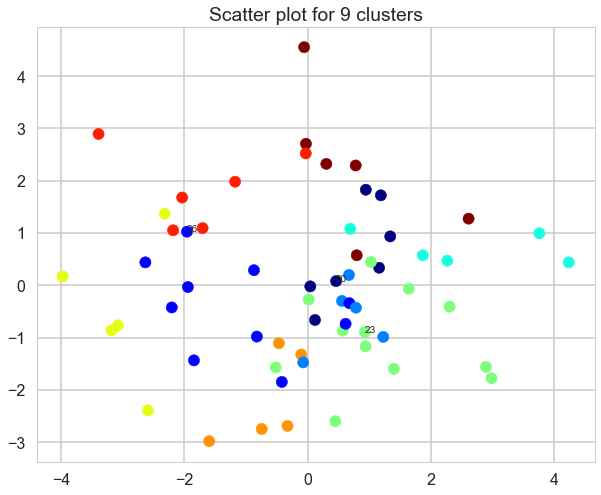

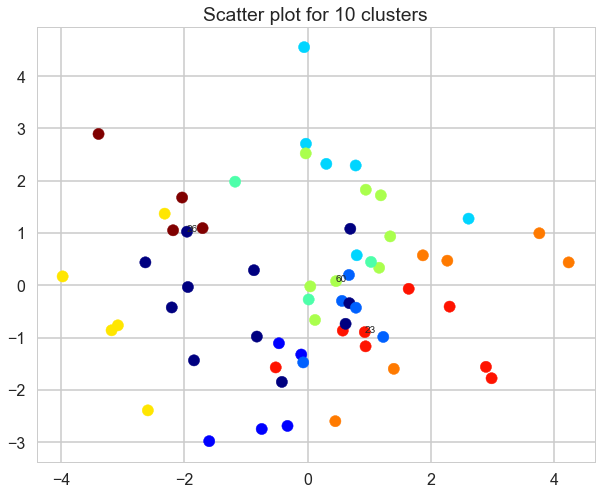

In [28]:
%matplotlib inline
k_range = range(2,11)
for n_clusters in k_range:
    kmeanscluster = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    df['cluster'] = kmeanscluster.fit_predict(df[feature_cols])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    fig.set_size_inches(10, 8)
    ax1.scatter(df['x'],df['y'],c=df['cluster'], cmap='jet')
    ax1.set_title("Scatter plot for %d clusters"%n_clusters)
    for i in [60,26,23]:
        ax1.annotate(i, (df['x'][i],df['y'][i]))
    plt.show()
    del df['cluster']

With three clusters there is minimum overalap and we get distinct groups of data points and the elblow curve has largest slope between 2 and 3. Hence chosing <b>3</b> as the final number of clusters.

In [29]:
kmeanscluster = sklearn.cluster.KMeans(n_clusters=3, random_state=10)
df['cluster'] = kmeanscluster.fit_predict(df[feature_cols])

In [30]:
#kmeanscluster.cluster_centers_

In [31]:
kmeanscluster.labels_

array([1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 1, 1, 2, 0,
       2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0])

In [32]:
df = pd.concat([df, pd.DataFrame(kmeanscluster.fit_transform(df[feature_cols]).tolist(),  columns=['cluster_x','cluster_y', 'cluster_z'])], axis=1)

In [33]:
df.head()

,bpm,spectral_centroid_avg,spectral_bw_avg,Chroma_A,Chroma_A#,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,Chroma_D#,...,Chroma_F#,Chroma_G,Chroma_G#,x,y,z,cluster,cluster_x,cluster_y,cluster_z
0,-0.106088,0.392756,0.838097,1.341396,0.442128,-1.103446,-0.983774,0.158718,-0.596200,0.234981,...,-2.499480,-2.303520,-0.672877,-2.318860,1.369202,-2.858838,1,4.706903,3.560317,5.282977
1,-0.106088,-0.295178,-0.451181,0.751337,0.204818,-0.810637,-1.188572,1.149090,1.563927,-0.047121,...,-0.680623,-0.921784,-0.264912,-0.027031,2.705591,-0.677127,0,2.631272,3.466140,4.453360
2,-0.224732,1.420504,0.370527,-1.312636,-0.064678,1.843617,0.643285,-1.005027,-0.862369,0.590807,...,1.399307,-0.024772,-1.747308,-0.744579,-2.747391,1.138584,2,5.025257,4.925557,3.072506
3,-0.446546,0.715256,0.121119,-0.455925,0.018834,0.175453,-0.213685,1.089417,2.014804,0.903538,...,-0.488818,-0.382581,-0.962552,0.780193,2.290298,0.351010,0,3.063099,4.661829,4.480070
4,-0.106088,-0.094908,-0.851252,1.014053,2.376781,0.895647,-2.596445,-1.213412,1.262394,2.167771,...,-0.962227,-0.232267,-0.833779,-3.391593,2.892720,2.084438,1,5.730130,3.530309,6.034627


In [34]:
## Tried the Affinity propogation method but then decided not to use the eight clusters suggested by it.
#model = sklearn.cluster.AffinityPropagation()
#labels = model.fit_predict(df[feature_cols])
#print(labels)

In [35]:
df['cluster_dist'] = df.loc[:, ['cluster_x', 'cluster_y', 'cluster_y']].min(axis=1)

In [36]:
df.groupby(['cluster']).agg({"cluster_dist": [min, max]})

cluster_dist          
                 min       max
cluster                       
0           1.951767  5.548731
1           2.012945  4.349088
2           2.824447  5.787949

In [37]:
df.loc[df.groupby('cluster').cluster_dist.idxmin()]

,bpm,spectral_centroid_avg,spectral_bw_avg,Chroma_A,Chroma_A#,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,Chroma_D#,...,Chroma_G,Chroma_G#,x,y,z,cluster,cluster_x,cluster_y,cluster_z,cluster_dist
60,-1.245073,0.043260,-0.354960,0.143605,-0.560218,-0.244462,0.674848,0.472613,-0.216187,0.132353,...,0.082978,0.769480,0.461948,0.079843,-0.502563,0,1.951767,3.575597,2.812776,1.951767
26,-0.106088,-0.404378,-0.452510,1.501887,1.518587,-0.172079,-1.455747,-0.611715,0.264786,-0.349293,...,-0.964361,-0.812564,-1.957170,1.024889,0.035763,1,3.978927,2.012945,4.036837,2.012945
23,0.580800,-0.048313,-0.589111,-1.145304,-0.670518,0.420251,0.456908,-0.199284,-0.312877,0.162667,...,1.133802,0.468747,0.927969,-0.895214,1.201528,2,2.824447,4.113997,1.823989,2.824447


In [38]:
df.groupby('cluster').mean()

,bpm,spectral_centroid_avg,spectral_bw_avg,Chroma_A,Chroma_A#,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,Chroma_D#,...,Chroma_F#,Chroma_G,Chroma_G#,x,y,z,cluster_x,cluster_y,cluster_z,cluster_dist
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.508508,0.130931,0.177591,0.038081,-0.589656,-0.743306,0.113849,0.702643,0.721854,0.076446,...,-0.067704,0.126533,0.409628,1.158482,0.979691,-0.357583,3.405299,4.926608,4.372022,3.405299
1,0.195326,-0.213449,-0.616192,1.010168,1.190676,0.173671,-1.103071,-0.798949,-0.167025,0.487523,...,-0.683289,-0.649299,-0.264451,-2.331899,0.707240,0.102006,4.695959,2.974614,4.525026,2.974614
2,0.411723,-0.006698,0.189761,-0.654622,-0.109465,0.669911,0.552636,-0.246875,-0.651572,-0.376522,...,0.486563,0.263191,-0.266468,0.210566,-1.452780,0.311040,4.380319,4.777600,3.325696,4.201073


In [39]:
clusters = df.groupby('cluster')

In [40]:
finalfive = pd.DataFrame(columns=musicdf.columns)
for name, group in clusters: 
    # print the name of the regiment
    print(name)
    # print the data of that regiment
    #print(musicdf.iloc[group.nsmallest(5, 'cluster_dist').index])
    finalfive = pd.concat([finalfive, musicdf.iloc[group.nsmallest(5, 'cluster_dist').index]])


0
1
2


In [41]:
finalfive.file

60                       br_im6.mp3
48                      bor_ps2.mp3
29                       mond_2.mp3
9                       alb_se4.mp3
1                      alb_esp2.mp3
26           beethoven_opus22_3.mp3
27           beethoven_opus22_4.mp3
13                      alb_se8.mp3
39       beethoven_les_adieux_3.mp3
42           beethoven_opus90_2.mp3
23                 pathetique_3.mp3
44    beethoven_hammerklavier_2.mp3
31                  waldstein_1.mp3
50                      bor_ps4.mp3
56               brahms_opus1_3.mp3
Name: file, dtype: object

In [42]:
musicdf.iloc[[60,26,23]]

,composer,description,symphony,file,part,tempo,bpm,duration,zero_crossings,spectral_centroid_avg,...,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,Chroma_D#,Chroma_E,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#
60,brahms,Brahms Johannes(1833-1897),7 Fantasia Opus 116,br_im6.mp3,No. 6 - Intermezzo,Andantino teneramente,93.963068,30.002698,32725,599.691516,...,0.198154,0.284025,0.261316,0.221709,0.263212,0.288369,0.244221,0.203382,0.257653,0.307077
26,beethoven,Beethoven Ludwig van(1770-1827),Sonata No. 11 Bb major Opus 22,beethoven_opus22_3.mp3,3. Movement,Minuetto,120.185320,30.002698,29437,547.193626,...,0.202896,0.142767,0.171497,0.259731,0.229353,0.198080,0.270524,0.248272,0.166534,0.196008
23,beethoven,Beethoven Ludwig van(1770-1827),Sonata No. 8 C minor(Pathetique) Opus 13,pathetique_3.mp3,3. Movement,Rondo allegro,135.999178,30.002698,33210,588.952085,...,0.241704,0.269576,0.205660,0.214065,0.265343,0.233110,0.208253,0.270175,0.349075,0.285964


In [43]:
df = df.iloc[finalfive.index]

The <b> final 15 </b> (five from each of the 3 clusters) thirty second clip that are chosen

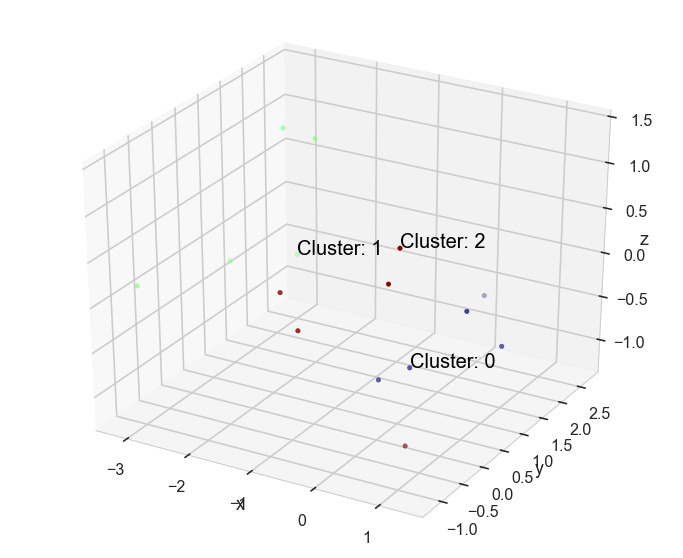

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(12, 10)).gca(projection='3d')
threedee.scatter(df.x, df.y, df.z,c=df['cluster'], cmap='jet')
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
j = 0;
for i in [60,26,23]:
    threedee.text(df.x[i],df.y[i], df.z[i],  'Cluster: %s' % (str(j)), size=20, zorder=1, color='k')
    j+=1
plt.show()